In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from python_speech_features import mfcc,logfbank
import psutil
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader,TensorDataset,WeightedRandomSampler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import sounddevice as sd
import torch.nn as nn



## Creating plots function

In [3]:
def plot_signal(signals):
    fig,axes = plt.subplots(nrows=1,ncols=2,
    sharex=False,sharey=True,figsize=(20,5))

    
    fig.suptitle("Time Series",size=16)
    for i in range(2):
            print(i)
            title = list(signals.keys())[i]
            data = list(signals.values())[i]
            axes[i].set_title(title)
            
            axes[i].plot(data)
            axes[i].get_yaxis().set_visible(False)
            axes[i].get_xaxis().set_visible(False)

            
            

In [4]:
def plot_fft(fft):
    fig,axes = plt.subplots(nrows=1,ncols=2,
    sharex=False,sharey=True,figsize=(20,5))

    
    fig.suptitle("Fourier Transform",size=16)
    for x in range(2):
            data = list(fft.values())[x]
            Y,fred = data[0], data[1]
            axes[x].set_title(list(fft.keys())[x])
            axes[x].plot(fred,Y)
            axes[x].get_yaxis().set_visible(False)
            axes[x].get_xaxis().set_visible(False)



In [5]:
def plot_fbanks(fbanks):
    fig,axes = plt.subplots(nrows=1,ncols=2,
    sharex=False,sharey=True,figsize=(5,5))

    
    fig.suptitle("Filter Bank Coefficient",size=16)

    for x in range(2):
            axes[x].set_title(list(fbanks.keys())[x])
            axes[x].imshow(list(fbanks.values())[x],
                           cmap="hot",interpolation="nearest")
            axes[x].get_yaxis().set_visible(False)
            axes[x].get_xaxis().set_visible(False)


In [6]:
def plot_mfcc(mfcc):
    fig,axes = plt.subplots(nrows=1,ncols=2,
    sharex=False,sharey=True,figsize=(5,5))

    
    fig.suptitle("Mel Frequence Cepstrum Coefficient",size=16)
    for x in range(2):
            axes[x].set_title(list(mfcc.keys())[x])
            axes[x].imshow(list(mfcc.values())[x],
                           cmap="hot",interpolation="nearest")
            axes[x].get_yaxis().set_visible(False)
            axes[x].get_xaxis().set_visible(False)


In [7]:
def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)

    return (Y,freq)

In [8]:
def envelope(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)

    return mask

## Load raw into pandas dataframe

In [9]:
os.chdir("../")

In [10]:
train_data_location_bg = "data/data/Training data/background"
train_data_location_gun = "data/data/Training data/Gunshot"

validation_data_location_bg = "data/data/Validation data/Background"
validation_data_location_gun = "data/data/Validation data/Gunshot"

## Loop Through All Audio File, Remain It,Skip All The Empty Audio File Then Put All The Audio File Path In A DataFrame With It Corespondind target label 

In [11]:
# Loops through all file
data_loc_dict = {train_data_location_bg:"Background",train_data_location_gun:"Gun_Shot",
                 validation_data_location_bg:"Background",validation_data_location_gun:"Gun_Shot"}
audio_data = []
audio_label = []

count = 1
if not os.path.exists("data/data/Training data/background/audio1.wav"):
    for filpath,label in data_loc_dict.items():

            if not os.path.exists(filpath):
                raise  ValueError( "No such file or directory")
            

            for filename in tqdm(os.listdir(filpath)):
                
                #print(f"{filename} {label}")
                if filename.endswith(".wav") or filename.endswith(".WAV"):
                    old_file_path = os.path.join(filpath,filename)

                    new_file_name = f'audio{count}.wav'
                    new_path = os.path.join(filpath,new_file_name)
                    os.rename(old_file_path,new_path)

                    if  os.path.getsize(new_path) == 0:
                        print(f"Skipping empty file: {filename}")
                        continue

                    
                    audio_data.append(new_path)
                    audio_label.append(label)
                    

                    count += 1


    audio_df = pd.DataFrame(data={"File_name":audio_data,
                                            "Label":audio_label})
    audio_df.to_csv("data/data/audio_df.csv",index=False)




In [12]:
audio_df = pd.read_csv("data/data/audio_df.csv")
audio_df["Label"].unique()
audio_df.set_index("File_name",inplace=True)
audio_df

,Label,Length
File_name,,
data/data/Training data/background/audio1.wav,Background,4.000000
data/data/Training data/background/audio2.wav,Background,4.000000
data/data/Training data/background/audio3.wav,Background,4.000000
data/data/Training data/background/audio4.wav,Background,4.000000
data/data/Training data/background/audio5.wav,Background,4.000000
...,...,...
data/data/Validation data/Gunshot/audio13381.wav,Gun_Shot,3.750000
data/data/Validation data/Gunshot/audio13382.wav,Gun_Shot,5.678118
data/data/Validation data/Gunshot/audio13383.wav,Gun_Shot,5.332562


### Rate (or sample_rate) It’s the number of audio samples per second.

* Unit: Hertz (Hz) → samples per second.

#### Example:

* in this project our  rate = 8000,
* it means there are 8000 samples in every second of sound.

* its called the sampling frequency or sampling rate.


### Signal It’s a NumPy array that contains the actual audio data (the waveform).

* Each value in signal represents how loud the sound is at a specific time (the amplitude).
* In this project our total sigal per audio is 32 ,000


## Two calcuate the duration of our audio files we divide rate or sample_rate by total sigal



In [13]:
for f in tqdm(audio_df.index):
    f = f.strip()

    if not os.path.exists(f):
        print(f"Skipping missing file: {f}")
        continue

    if os.path.getsize(f) == 0:
        print(f"Skipping empty file: {f}")
        continue

    try:
        rate, signal = wavfile.read(f)
        #print(signal.shape)
        # This calculates the audio duration and # positional base indexing 
        
        audio_df.at[f, "Length"] = signal.shape[0] / rate
    except Exception as e:
        print(f"Error reading {f}: {e}")

audio_df.reset_index(inplace=True)
audio_df.to_csv("data/data/audio_df.csv",index=False)



 27%|██▋       | 3615/13385 [00:01<00:04, 1986.25it/s]/tmp/ipykernel_7996/3099130880.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read(f)
100%|██████████| 13385/13385 [00:09<00:00, 1409.83it/s]


In [14]:

audio_df = audio_df.dropna()

## Checking the  distribution of our data with respect to lebel

In [15]:
audio_df

,File_name,Label,Length
0,data/data/Training data/background/audio1.wav,Background,4.000000
1,data/data/Training data/background/audio2.wav,Background,4.000000
2,data/data/Training data/background/audio3.wav,Background,4.000000
3,data/data/Training data/background/audio4.wav,Background,4.000000
4,data/data/Training data/background/audio5.wav,Background,4.000000
...,...,...,...
13380,data/data/Validation data/Gunshot/audio13381.wav,Gun_Shot,3.750000
13381,data/data/Validation data/Gunshot/audio13382.wav,Gun_Shot,5.678118
13382,data/data/Validation data/Gunshot/audio13383.wav,Gun_Shot,5.332562
13383,data/data/Validation data/Gunshot/audio13384.wav,Gun_Shot,4.000000


In [16]:
classes = audio_df["Label"].unique()
classes_dict = audio_df.groupby(["Label"])["Length"].mean()

In [17]:
classes

array(['Background', 'Gun_Shot'], dtype=object)

## Pie Chart of Mean Audio Length for Each Unique Label

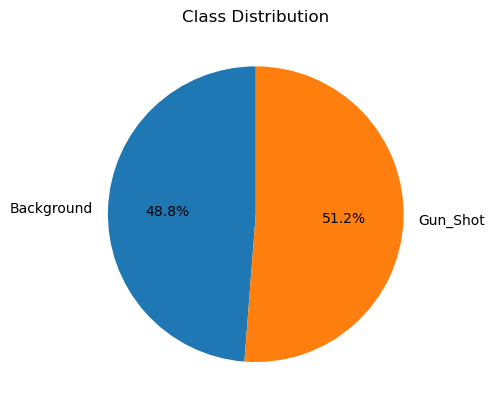

In [18]:
fig , ax = plt.subplots()

ax.set_title("Class Distribution",y=1)
ax.pie(classes_dict,labels=classes,autopct="%1.1f%%",shadow=False,startangle=90)
plt.show()

## Pie Chart of Total Audio Length for Each Target Label

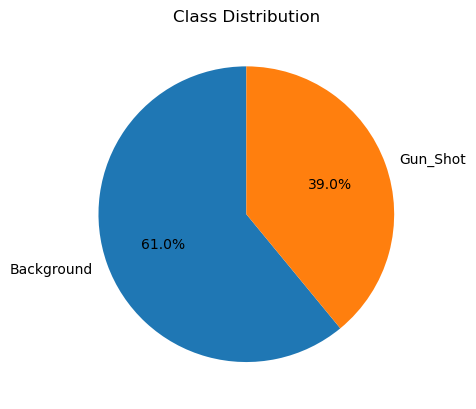

In [19]:
classes = audio_df["Label"].value_counts().index

classes_dict = audio_df["Label"].value_counts()

fig , ax = plt.subplots()

ax.set_title("Class Distribution",y=1)
ax.pie(classes_dict,labels=classes,autopct="%1.1f%%",shadow=False,startangle=90)
plt.show()

In [20]:
## Reset the index
audio_df.reset_index(inplace=True)

In [21]:
signals = {}
fft = {}
fbank = {}
mfccs = {}


for c in classes:
    wav_file = audio_df[audio_df["Label"] == c].iloc[0,1]
    print(wav_file)
    signal,rate = librosa.load(wav_file,sr=8000)
    mask = envelope(signal,rate,0.0005)
    signal = signal[mask]
    signals[c] = signal

    fft[c] = calc_fft(signal,rate)

    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=800)
    fbank[c] = bank

    mel = mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=800)
    mfccs[c] = mel




data/data/Training data/background/audio1.wav
data/data/Training data/Gunshot/audio3761.wav


## PLoting audio features

0
1


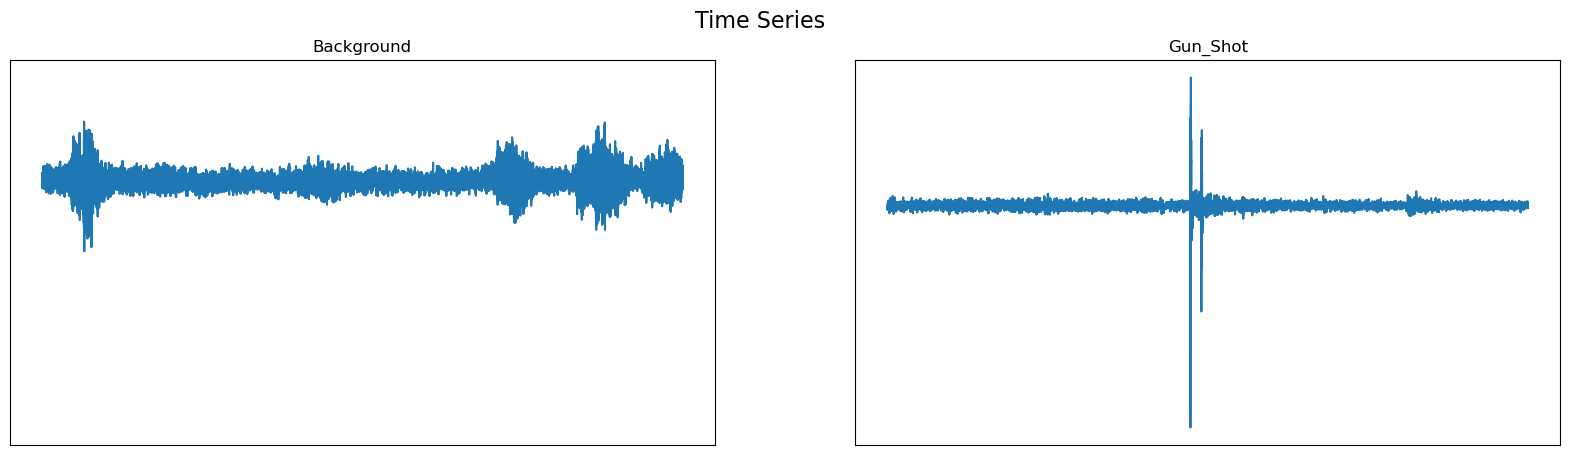

In [22]:
plot_signal(signals)
plt.show()

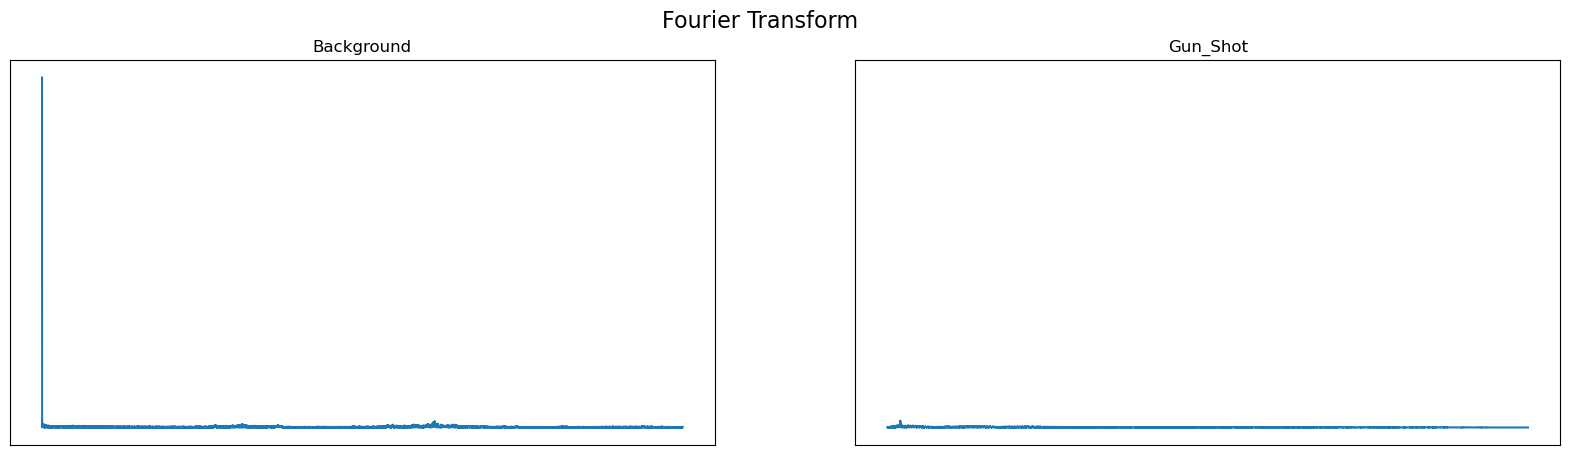

In [23]:
plot_fft(fft)
plt.show()

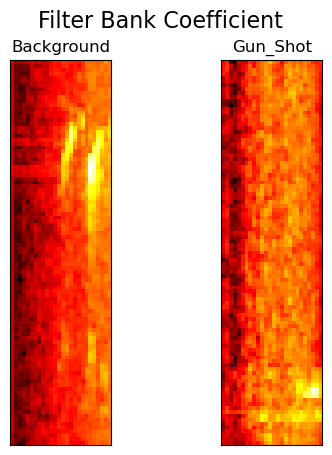

In [24]:
plot_fbanks(fbank)
plt.show()

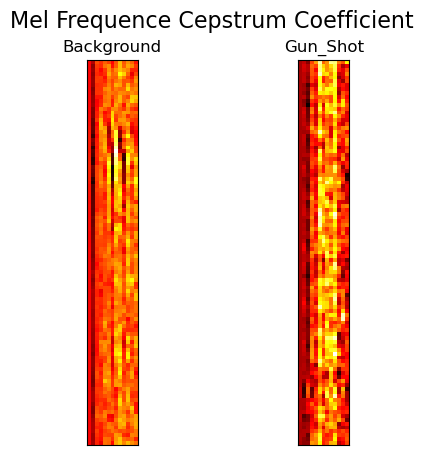

In [25]:
plot_mfcc(mfccs)

## Save clean audio file

In [26]:
audio_df["File_name"]

0           data/data/Training data/background/audio1.wav
1           data/data/Training data/background/audio2.wav
2           data/data/Training data/background/audio3.wav
3           data/data/Training data/background/audio4.wav
4           data/data/Training data/background/audio5.wav
                               ...                       
13380    data/data/Validation data/Gunshot/audio13381.wav
13381    data/data/Validation data/Gunshot/audio13382.wav
13382    data/data/Validation data/Gunshot/audio13383.wav
13383    data/data/Validation data/Gunshot/audio13384.wav
13384    data/data/Validation data/Gunshot/audio13385.wav
Name: File_name, Length: 13385, dtype: object

In [27]:
output_dir = "data/data/clean_audio_data"
os.makedirs(output_dir, exist_ok=True)

if len(os.listdir(output_dir)) == 0:
    for f in tqdm(audio_df["File_name"]):
        f = f.strip()

        if not os.path.exists(f) or os.path.getsize(f) == 0:
            continue

        try:
            signal, rate = librosa.load(f, sr=8000)
            mask = envelope(signal, rate, 0.0005)

            # Get only the filename part (without path)
            file_name = os.path.basename(f)

            # Create full path for the new clean file
            clean_path = os.path.join(output_dir, file_name)

            # Save cleaned audio
            wavfile.write(clean_path, rate, signal[mask])

        except Exception as e:
            print(f"Error reading {f}: {e}")


## Getting data ready and also training model

In [28]:
audio_df

,index,File_name,Label,Length
0,0,data/data/Training data/background/audio1.wav,Background,4.000000
1,1,data/data/Training data/background/audio2.wav,Background,4.000000
2,2,data/data/Training data/background/audio3.wav,Background,4.000000
3,3,data/data/Training data/background/audio4.wav,Background,4.000000
4,4,data/data/Training data/background/audio5.wav,Background,4.000000
...,...,...,...,...
13380,13380,data/data/Validation data/Gunshot/audio13381.wav,Gun_Shot,3.750000
13381,13381,data/data/Validation data/Gunshot/audio13382.wav,Gun_Shot,5.678118
13382,13382,data/data/Validation data/Gunshot/audio13383.wav,Gun_Shot,5.332562
13383,13383,data/data/Validation data/Gunshot/audio13384.wav,Gun_Shot,4.000000


In [29]:
audio_df = pd.read_csv("data/data/audio_df.csv")

In [30]:
audio_df.set_index("File_name",inplace=True)

In [31]:
audio_df

,Label,Length
File_name,,
data/data/Training data/background/audio1.wav,Background,4.000000
data/data/Training data/background/audio2.wav,Background,4.000000
data/data/Training data/background/audio3.wav,Background,4.000000
data/data/Training data/background/audio4.wav,Background,4.000000
data/data/Training data/background/audio5.wav,Background,4.000000
...,...,...
data/data/Validation data/Gunshot/audio13381.wav,Gun_Shot,3.750000
data/data/Validation data/Gunshot/audio13382.wav,Gun_Shot,5.678118
data/data/Validation data/Gunshot/audio13383.wav,Gun_Shot,5.332562


In [32]:
audio_df["Label"] = audio_df["Label"].map({"Background":0,"Gun_Shot":1})

In [33]:
audio_df["Label"].value_counts()

Label
0    8160
1    5225
Name: count, dtype: int64

In [34]:


for f in tqdm(audio_df.index):
    file_name = os.path.basename(f)
    rate,signal = wavfile.read("data/data/clean_audio_data/"+file_name)

classes = audio_df["Label"].unique()
classes_dict = audio_df.groupby(["Label"])["Length"].mean()


n_samples = 2 * int(audio_df["Length"].sum()/0.1)
prob_dist = classes_dict / classes_dict.sum()
choices = np.random.choice(classes_dict.index,p=prob_dist)


100%|██████████| 13385/13385 [00:05<00:00, 2438.99it/s]


In [35]:
audio_df

,Label,Length
File_name,,
data/data/Training data/background/audio1.wav,0,4.000000
data/data/Training data/background/audio2.wav,0,4.000000
data/data/Training data/background/audio3.wav,0,4.000000
data/data/Training data/background/audio4.wav,0,4.000000
data/data/Training data/background/audio5.wav,0,4.000000
...,...,...
data/data/Validation data/Gunshot/audio13381.wav,1,3.750000
data/data/Validation data/Gunshot/audio13382.wav,1,5.678118
data/data/Validation data/Gunshot/audio13383.wav,1,5.332562


In [109]:
class Config:
    def __init__(self, mode="conv", nfilt=40, nfeat=13, nfft=2048, rate=48000):
        self.mode = mode
        self.nfilt = nfilt          # number of Mel filters
        self.nfeat = nfeat          # number of MFCC features
        self.nfft = nfft            # FFT window size (larger = better frequency resolution)
        self.rate = rate            # sample rate in Hz
        self.step = int(rate * 4)   # 4 seconds per audio sample


In [110]:
config = Config()

In [111]:
df = audio_df

In [112]:
audio_df_train,audio_df_test = train_test_split(audio_df,test_size=.2,random_state=42)

In [113]:
audio_df_train

,Label,Length
File_name,,
data/data/Training data/background/audio3488.wav,0,4.000000
data/data/Training data/background/audio3290.wav,0,4.000000
data/data/Training data/background/audio415.wav,0,4.000000
data/data/Training data/Gunshot/audio6561.wav,1,5.548934
data/data/Validation data/Background/audio7454.wav,0,4.000000
...,...,...
data/data/Validation data/Gunshot/audio11965.wav,1,3.750000
data/data/Training data/Gunshot/audio5192.wav,1,6.275533
data/data/Training data/Gunshot/audio5391.wav,1,3.750000


In [117]:
def build_all_feat(audio_df_):
    import gc

    gc.collect()  # Frees memory, indirectly reducing CPU pressure

    i = 0
    print("Available memory:", psutil.virtual_memory().available / 1e9, "GB")
    X, y = [],[]
    _min, _max = float("inf"), -float("inf")
    for file in tqdm(audio_df_.index):
        filename = os.path.basename(file)
        filepath = f"data/data/clean_audio_data/{filename}"
        #print(filepath)
        # skip missing or empty files
        if not os.path.exists(filepath) or os.path.getsize(filepath) == 0:
            continue

        try:
            wav,rate = librosa.load(file,sr=config.rate)
            if len(wav) < config.step:
                continue  # skip too-short audio

            # take first 4 seconds only
            wav = wav[:config.step]

            # extract MFCC features
            X_sample = mfcc(
                wav, rate,
                numcep=config.nfeat,
                nfilt=config.nfilt,
                nfft=config.nfft
            ).T

            # update min/max for normalization
            _min = min(np.amin(X_sample), _min)
            _max = max(np.amax(X_sample), _max)

            X.append(X_sample)
            y.append(audio_df_.at[file, "Label"])
            

        except Exception as e:
            print(f"Error processing {filepath}: {e}")
       
    # convert to NumPy arrays
    X = np.array([x for x in X if x.shape == X[0].shape])
    y = np.array(y)

    # normalize between 0 and 1
    X = (X - _min) / (_max - _min)

    # reshape for CNN input
    X = X[..., np.newaxis]
    return X, y


In [118]:
config = Config()
if config.mode == "conv":
    X_train,y_train = build_all_feat(audio_df_=audio_df_train)
    X_test,y_test = build_all_feat(audio_df_=audio_df_test)
elif config.mode == "time":
    X,y = build_all_feat()

Available memory: 7.515869184 GB


100%|██████████| 10708/10708 [06:31<00:00, 27.35it/s]


Available memory: 7.747964928 GB


100%|██████████| 2677/2677 [01:38<00:00, 27.31it/s]


In [119]:
X_train.shape

(8405, 13, 399, 1)

In [120]:
print(type(X_train))
print(type(X_train[0]))
print(X_train[0].shape)
print(X_train.dtype)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(13, 399, 1)
float64


In [121]:
def plot_spectrogram(y, y_axis="linear", TITLE=""):
    plt.figure(figsize=(10, 5))  
    plt.title(TITLE)
    librosa.display.specshow(
        y,
        x_axis="time",
        y_axis=y_axis
    )
    plt.colorbar(format="%+2.f")  
    plt.xlabel("Time")
    plt.ylabel("Hz")
    plt.show()

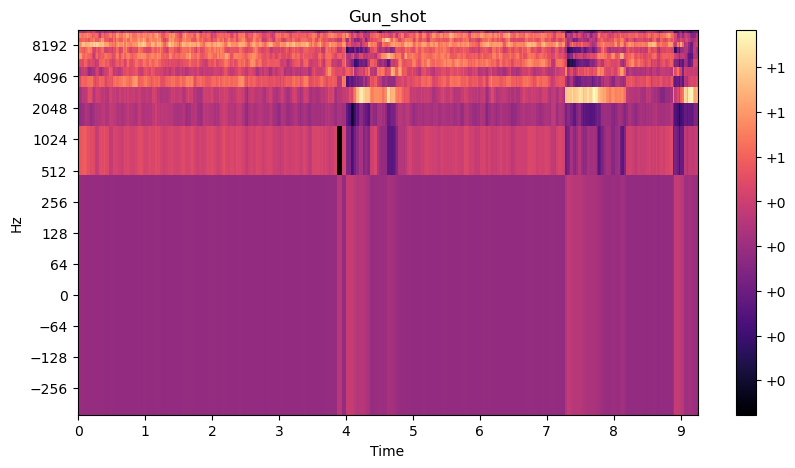

In [122]:
plot_spectrogram(X_train[y_train == 1][3].squeeze(),TITLE="Gun_shot",y_axis="log")

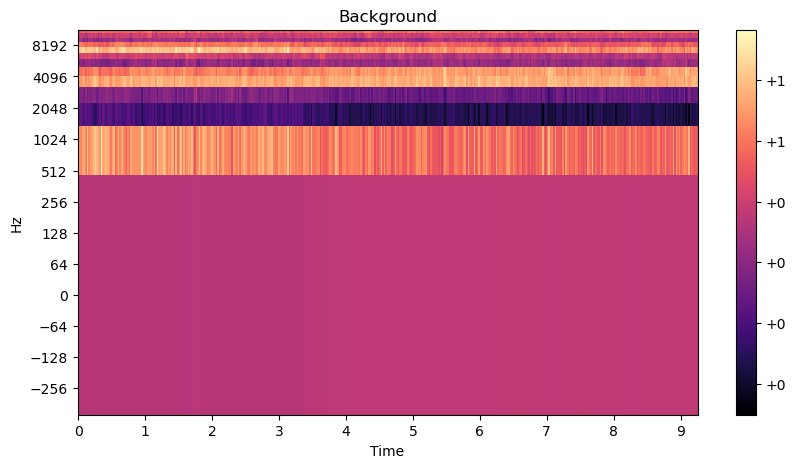

In [123]:
plot_spectrogram(X_train[y_train == 0][9].squeeze(),TITLE="Background",y_axis="log")

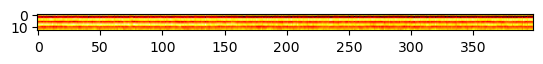

In [124]:
plt.imshow(X_train[y_train == 0][9].squeeze(),cmap="hot")

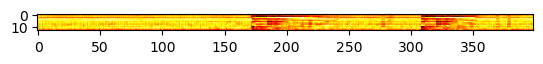

In [125]:
plt.imshow(X_train[y_train == 1][0].squeeze(),cmap="hot")

In [126]:
X_train,y_train = torch.tensor(X_train).float(),torch.tensor(y_train).float()
X_test,y_test = torch.tensor(X_test).float(),torch.tensor(y_test).float()

In [127]:
x_y_train = TensorDataset(X_train,y_train)
x_y_test = TensorDataset(X_test,y_test)

In [128]:
class AudioCNN(nn.Module):
    def __init__(self, n_classes, in_channels=1, dropout=0.4):
        super().__init__()

        self.net = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2)
        )

        # Adaptive pooling for fixed-size output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.net(x)
        x = self.adaptive_pool(x)
        x = self.fc(x)
        return x


def get_optimizer(weight=None):
    net = AudioCNN(n_classes=1)
    # Add class weight handling if imbalance exists
    lossFun = nn.BCEWithLogitsLoss(pos_weight=weight)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, weight_decay=1e-5)
    return net, lossFun, optimizer



In [129]:
net,lossFun,optim =  get_optimizer()

In [130]:


train_loader = DataLoader(x_y_train,batch_size=32,drop_last=True)
length = len(x_y_test)
test_loader = DataLoader(x_y_test,batch_size=32,shuffle=False,drop_last=True)

In [131]:
X,y = next(iter(train_loader))
print(X.shape)
y_pred = net(X.permute(0,3,1,2))
lossFun(y_pred.squeeze(),y)

torch.Size([32, 13, 399, 1])


tensor(0.7542, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [132]:
def train_model(x_y_train_loader, device, x_y_dev_loader):
    torch.cuda.empty_cache()
    
    # get model, loss, optimizer
    net, lossFun, optimizer = get_optimizer()
    net.to(device)

    num_epochs = 20   # you can increase this later for better accuracy
    accumulation_steps = 16

    # logs
    train_acc, train_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    val_acc, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)

    for epoch in tqdm(range(num_epochs)):
        net.train()
        optimizer.zero_grad()

        batch_losses, batch_accs = [], []

        # --- Training Loop --- #
        for i, (X, y) in enumerate(x_y_train_loader):
            X = X.to(device)
            y = y.to(device).float().view(-1, 1)  # ensure shape (B,1) for BCE loss

            # Forward
            y_pred = net(X.permute(0, 3, 1, 2))

            # Compute loss
            loss = lossFun(y_pred, y)
            loss = loss / accumulation_steps
            loss.backward()

            # Update weights after several batches
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(x_y_train_loader):
                optimizer.step()
                optimizer.zero_grad()

            # Accuracy
            preds = (y_pred >= 0.5).float()
            acc = (preds == y).float().mean().item()
            
            batch_losses.append(loss.item() * accumulation_steps)
            batch_accs.append(acc)

        train_loss[epoch] = np.mean(batch_losses)
        train_acc[epoch] = np.mean(batch_accs)

        # --- Validation Loop --- #
        net.eval()
        val_losses, val_accs = [], []

        with torch.no_grad():
            for X_val, y_val in x_y_dev_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device).float().view(-1, 1)

                y_pred_val = net(X_val.permute(0, 3, 1, 2))
                v_loss = lossFun(y_pred_val, y_val)

                preds_val = (y_pred_val >= 0.5).float()
                v_acc = (preds_val == y_val).float().mean().item()

                val_losses.append(v_loss.item())
                val_accs.append(v_acc)

        val_loss[epoch] = np.mean(val_losses)
        val_acc[epoch] = np.mean(val_accs)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss[epoch]:.4f}, Train Acc: {train_acc[epoch]*100:.2f}% | "
              f"Val Loss: {val_loss[epoch]:.4f}, Val Acc: {val_acc[epoch]*100:.2f}%")

        torch.cuda.empty_cache()

    return train_loss, train_acc, val_loss, val_acc, net


In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [134]:
train_loss, train_acc, test_loss, test_acc, net = train_model(train_loader,device,test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:02<00:40,  2.15s/it]

Epoch 1/20 | Train Loss: 0.5306, Train Acc: 77.12% | Val Loss: 0.3500, Val Acc: 77.64%


 10%|█         | 2/20 [00:04<00:37,  2.09s/it]

Epoch 2/20 | Train Loss: 0.3722, Train Acc: 79.97% | Val Loss: 0.2957, Val Acc: 91.25%


 15%|█▌        | 3/20 [00:06<00:35,  2.10s/it]

Epoch 3/20 | Train Loss: 0.3316, Train Acc: 88.28% | Val Loss: 0.2546, Val Acc: 93.22%


 20%|██        | 4/20 [00:08<00:33,  2.10s/it]

Epoch 4/20 | Train Loss: 0.2912, Train Acc: 91.64% | Val Loss: 0.2293, Val Acc: 93.22%


 25%|██▌       | 5/20 [00:10<00:31,  2.12s/it]

Epoch 5/20 | Train Loss: 0.2733, Train Acc: 92.06% | Val Loss: 0.2166, Val Acc: 93.22%


 30%|███       | 6/20 [00:12<00:29,  2.09s/it]

Epoch 6/20 | Train Loss: 0.2549, Train Acc: 92.35% | Val Loss: 0.2083, Val Acc: 93.22%


 35%|███▌      | 7/20 [00:14<00:26,  2.04s/it]

Epoch 7/20 | Train Loss: 0.2466, Train Acc: 92.29% | Val Loss: 0.2024, Val Acc: 93.22%


 40%|████      | 8/20 [00:16<00:24,  2.02s/it]

Epoch 8/20 | Train Loss: 0.2371, Train Acc: 92.63% | Val Loss: 0.1988, Val Acc: 93.22%


 45%|████▌     | 9/20 [00:18<00:22,  2.02s/it]

Epoch 9/20 | Train Loss: 0.2287, Train Acc: 92.65% | Val Loss: 0.1944, Val Acc: 93.22%


 50%|█████     | 10/20 [00:20<00:20,  2.04s/it]

Epoch 10/20 | Train Loss: 0.2226, Train Acc: 92.59% | Val Loss: 0.1905, Val Acc: 93.22%


 55%|█████▌    | 11/20 [00:22<00:18,  2.05s/it]

Epoch 11/20 | Train Loss: 0.2193, Train Acc: 92.63% | Val Loss: 0.1883, Val Acc: 93.22%


 60%|██████    | 12/20 [00:24<00:16,  2.05s/it]

Epoch 12/20 | Train Loss: 0.2203, Train Acc: 92.66% | Val Loss: 0.1852, Val Acc: 93.22%


 65%|██████▌   | 13/20 [00:26<00:14,  2.05s/it]

Epoch 13/20 | Train Loss: 0.2145, Train Acc: 92.74% | Val Loss: 0.1828, Val Acc: 93.22%


 70%|███████   | 14/20 [00:28<00:12,  2.05s/it]

Epoch 14/20 | Train Loss: 0.2106, Train Acc: 92.69% | Val Loss: 0.1797, Val Acc: 93.22%


 75%|███████▌  | 15/20 [00:30<00:10,  2.06s/it]

Epoch 15/20 | Train Loss: 0.2109, Train Acc: 92.70% | Val Loss: 0.1798, Val Acc: 93.22%


 80%|████████  | 16/20 [00:32<00:08,  2.04s/it]

Epoch 16/20 | Train Loss: 0.2110, Train Acc: 92.68% | Val Loss: 0.1788, Val Acc: 93.22%


 85%|████████▌ | 17/20 [00:34<00:06,  2.05s/it]

Epoch 17/20 | Train Loss: 0.2051, Train Acc: 92.72% | Val Loss: 0.1782, Val Acc: 93.22%


 90%|█████████ | 18/20 [00:37<00:04,  2.06s/it]

Epoch 18/20 | Train Loss: 0.2063, Train Acc: 92.76% | Val Loss: 0.1757, Val Acc: 93.22%


 95%|█████████▌| 19/20 [00:39<00:02,  2.04s/it]

Epoch 19/20 | Train Loss: 0.2029, Train Acc: 92.81% | Val Loss: 0.1736, Val Acc: 93.22%


100%|██████████| 20/20 [00:41<00:00,  2.06s/it]

Epoch 20/20 | Train Loss: 0.1974, Train Acc: 92.86% | Val Loss: 0.1737, Val Acc: 93.22%


In [135]:
preds = []
labels = []
val_losses = []

net.eval()  # set model to eval mode

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # CNN expects (B, C, H, W)
        y_pred = net(X_val.permute(0, 3, 1, 2))

        # compute loss
        val_loss = lossFun(y_pred.squeeze(), y_val.float())
        val_losses.append(val_loss.item())

        # for binary classification threshold = 0.5
        preds_batch = (torch.sigmoid(y_pred) >= 0.5).float().squeeze()

        preds.extend(preds_batch.cpu().numpy())
        labels.extend(y_val.cpu().numpy())


In [136]:
accuracy_score(y_pred=preds,y_true=labels)

0.9322115384615385

In [137]:
print(classification_report(y_pred=preds,y_true=labels))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1615
         1.0       1.00      0.70      0.82       465

    accuracy                           0.93      2080
   macro avg       0.96      0.85      0.89      2080
weighted avg       0.94      0.93      0.93      2080



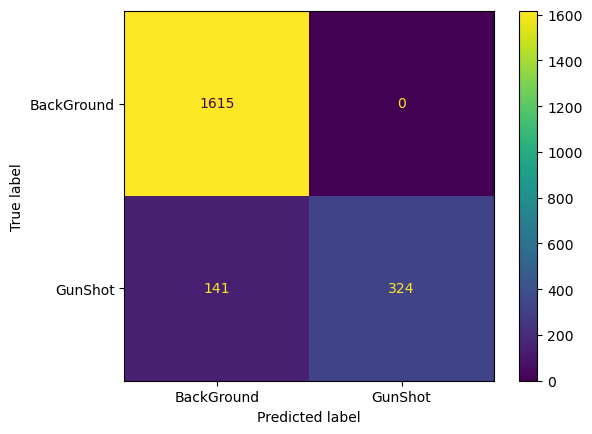

In [138]:
cm = confusion_matrix(y_pred=preds,y_true=labels)

ConfusionMatrixDisplay(cm,display_labels=["BackGround","GunShot"]).plot()

## Calculate our false alarm rate according to this project our **FAR** show be less than 5% percent

### False alarm rate is how we measures how often our model raise a flase alarm i.e our model predict gunshot when there was actually no gunshot

In [139]:
FAR = cm[0][1]/(cm[0][0]+cm[0][1])
print(FAR)

0.0


## Our **FAR** is approtimately 0.0025 which is  less than 5 percent

In [140]:
test_audio_path = "data/data/audio2.wav"

In [141]:
def build_all_feat(path):
   
    X = []
    _min, _max = float("inf"), -float("inf")
    try:
            wav,rate = librosa.load(path,sr=config.rate)

            # take first 4 seconds only
            wav = wav[:config.step]

            # extract MFCC features
            X_sample = mfcc(
                wav, rate,
                numcep=config.nfeat,
                nfilt=config.nfilt,
                nfft=config.nfft
            ).T

            # update min/max for normalization
            _min = min(np.amin(X_sample), _min)
            _max = max(np.amax(X_sample), _max)

            X.append(X_sample)
          
            

    except Exception as e:
            print(f"Error processing {path}: {e}")
       
    # convert to NumPy arrays
    X = np.array([x for x in X if x.shape == X[0].shape])
   

    # normalize between 0 and 1
    X = (X - _min) / (_max - _min)

    # reshape for CNN input
    X = X[..., np.newaxis]
    X =  torch.tensor(X).float().permute(0,3,1,2).to(device)
    return X

In [142]:
X = build_all_feat(test_audio_path)

In [143]:
y_pred =  (net(X) >= .5).float()


In [144]:
y_pred

tensor([[0.]], device='cuda:0')

In [151]:
# 🔹 Audio settings
SAMPLE_RATE = 48000  # 16kHz is standard
DURATION = 4  # seconds
THRESHOLD = 0.5  # decision threshold for gunshot detection
counts = 0
def extract_features(audio,rate=config.rate):
    """Extract MFCC features for prediction"""
    X = []
    
    _min, _max = float("inf"), -float("inf")
    try:
            os.makedirs("data/data/userinput/",exist_ok=True)
            wav = audio
            wavfile.write(filename=f"data/data/userinput/userinput{counts}.wav",rate=config.rate,data=wav)

            # take first 4 seconds only
            wav = wav[:config.step]

            # extract MFCC features
            X_sample = mfcc(
                wav, rate,
                numcep=config.nfeat,
                nfilt=config.nfilt,
                nfft=config.nfft
            ).T

            # update min/max for normalization
            _min = min(np.amin(X_sample), _min)
            _max = max(np.amax(X_sample), _max)

            X.append(X_sample)
            
          
            

    except Exception as e:
            print(f"Error processing {audio}: {e}")
       
    # convert to NumPy arrays
    X = np.array([x for x in X if x.shape == X[0].shape])
   

    # normalize between 0 and 1
    X = (X - _min) / (_max - _min)

    # reshape for CNN input
    X = X[..., np.newaxis]
    X =  torch.tensor(X).float().permute(0,3,1,2).to(device)
    return X
au = []
def predict(audio):
    """Run model prediction on recorded audio"""
    features = extract_features(audio).to(device)
    with torch.no_grad():
        output = net(features)
        prob = torch.sigmoid(output).item()
        return prob

print("🎧 Listening... press Ctrl+C to stop.")

try:
    while True:
        audio = sd.rec(int(SAMPLE_RATE * DURATION), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
        sd.wait()
        audio = audio.flatten()
        au.append(audio)

        prob = predict(audio)
        counts += 1
        if prob >= THRESHOLD:
            print("🚨 Gunshot detected! Probability:", round(prob, 3))
        else:
            print("🔈 BackGround sound. Probability:", round(prob, 3))

except KeyboardInterrupt:
    print("\n🛑 Stopped listening.")


🎧 Listening... press Ctrl+C to stop.
🚨 Gunshot detected! Probability: 0.578
🔈 BackGround sound. Probability: 0.446
🚨 Gunshot detected! Probability: 0.558
🚨 Gunshot detected! Probability: 0.539
🔈 BackGround sound. Probability: 0.204
🔈 BackGround sound. Probability: 0.049
🚨 Gunshot detected! Probability: 0.561
🔈 BackGround sound. Probability: 0.359
🚨 Gunshot detected! Probability: 0.98
🚨 Gunshot detected! Probability: 0.585
🔈 BackGround sound. Probability: 0.151
🔈 BackGround sound. Probability: 0.385
🚨 Gunshot detected! Probability: 0.99
🔈 BackGround sound. Probability: 0.248
🚨 Gunshot detected! Probability: 0.8
🚨 Gunshot detected! Probability: 0.926
🔈 BackGround sound. Probability: 0.212
🔈 BackGround sound. Probability: 0.331
🚨 Gunshot detected! Probability: 0.704
🔈 BackGround sound. Probability: 0.061
🚨 Gunshot detected! Probability: 0.962
🚨 Gunshot detected! Probability: 0.922
🚨 Gunshot detected! Probability: 0.67
🔈 BackGround sound. Probability: 0.489
🔈 BackGround sound. Probability:

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   1 HDA NVidia: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   2 HDA NVidia: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   3 HDA NVidia: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   4 HDA Intel PCH: ALC287 Analog (hw:1,0), ALSA (2 in, 2 out)
   5 HDA Intel PCH: HDMI 0 (hw:1,3), ALSA (0 in, 8 out)
   6 HDA Intel PCH: HDMI 1 (hw:1,7), ALSA (0 in, 8 out)
   7 HDA Intel PCH: HDMI 2 (hw:1,8), ALSA (0 in, 8 out)
   8 HDA Intel PCH: HDMI 3 (hw:1,9), ALSA (0 in, 8 out)
   9 hdmi, ALSA (0 in, 8 out)
  10 pipewire, ALSA (64 in, 64 out)
* 11 default, ALSA (64 in, 64 out)


Recording... Speak now!
Recording complete! Saved as test_mic.wav
